# Mid Semester Project - DEEP Reinforcements Learning
# ENV2 - KEY DOOR ENVIRONMENT
Dear students,<br> this is the template notebook. Please copy it by clicking on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1:
<br>
Student 2:
<br><br>
<img src="https://raw.githubusercontent.com/Farama-Foundation/Minigrid/master/minigrid-text.png">

### https://minigrid.farama.org/

# Pre-Requisit

## Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install gym-minigrid
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install -U --no-cache-dir gdown --pre

## Imports

In [ ]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


## Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

#Env2 - Key Door Env

## Class Env

In [ ]:
from __future__ import annotations
from gym_minigrid.minigrid import COLOR_NAMES
from gym_minigrid.minigrid import Grid
from gym_minigrid.minigrid import MissionSpace
from gym_minigrid.minigrid import Door, Goal, Key, Wall, Lava, Floor
from minigrid_x import MiniGridEnv
from gym import spaces
import random

class RandomKeyMEnv_10(MiniGridEnv):
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )
        self.partition_col = 3
        self.walls_init = [(self.partition_col, i) for i in range(0, self.grid.height)]
        self.goal_pos = (self.grid.width - 2, self.grid.height - 2)


    def get_pass_location(self):
      return (self.partition_col, self.pass_loc)

    def get_partition_column(self):
      return self.partition_col

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def get_k_pos(self):
      return self.key_pos

    def get_d_pos(self):
      return self.door_pos

    def _gen_grid(self, width, height):
        # Place Dor in random location within all column the partition
        self.pass_loc = random.choice([op_row for op_row in range(1, self.unwrapped.width-1)])

        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate verical separation wall
        # for i in range(0, height):
        #     self.grid.set(5, i, Wall())


        for column, row in self.walls_init:
          self.grid.set(column, row, Wall())

        # Place Key in random location within all the free spaces left to the partition
        self.key_pos = (random.choice([k_col for k_col in range(1,self.partition_col)]), random.choice([k_row for k_row in range(2,self.unwrapped.height-1)]))
        self.door_pos = (self.partition_col, self.pass_loc)

        self.env_door = Door(COLOR_NAMES[0], is_locked=True)

        # Place the Lava
        # self.grid.set(4, 6, Lava())

        # Place the door and key
        self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)
        self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))
        self.goal_pos = (width - 2, height - 2)
        # Place a goal square in the bottom-right corner
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"

    def is_carrying_key(self):
        if 'Key' in str(self.unwrapped.carrying):
            return True
        return False

    def is_door_open(self):
        return self.unwrapped.env_door.is_open

## WRAPPER

In [ ]:

ACTION_MAP = {0:0,
              1:1,
              2:2,
              3:3,
              4:5,
              5:5}


class KEYRGBImgObsWrapper(gym.core.ObservationWrapper):
    """
    Wrapper to use fully observable RGB image as the only observation output,
    no language/mission. This can be used to have the agent to solve the
    gridworld in pixel space.
    """

    def __init__(self, env, tile_size=32, plot=False, preprocess= lambda x: x):
        super().__init__(env)

        self.tile_size = tile_size
        self.plot = plot
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            # #the default is (320,320,3). Tile size  = 32 X 10 (grid size)
            # TODO: BE CAREFULL TO CHANGE the shape size to be according your preprocess size/channels
            # The env information i staken from here
            shape=(320, 320, 3),
            dtype='uint8'
        )
        self.prev_door = False
        self.prev_key = False
        self.action_space = spaces.Discrete(self.action_space.n - 2)

        #TODO: THINK AND TEST DIFFERENT PREPROCESS
        self._preprocess = lambda x: x


    def observation(self, obs):
      env = self.unwrapped

      # Call render without any unsupported keyword arguments
      rgb_img = env.render()  # Use the default rendering behavior
      return rgb_img

    def reset(self, seed = 0, options = None):
        self.prev_door = False
        self.prev_key = False
        obs, info = super().reset()
        if self.plot:
            plt.show()
        return self._preprocess(obs), info

    def step(self, action):
        action = ACTION_MAP[action]
        obs, r, d, info, x = super().step(action)
        obs = self._preprocess(obs)

        # TODO: REWARD SHAPING
        #we encourage you to come up with a better reward function using  self.is_door_open() and self.is_carrying_key()

        return obs, r, d, info, x



## Env Info

(320, 320, 3)


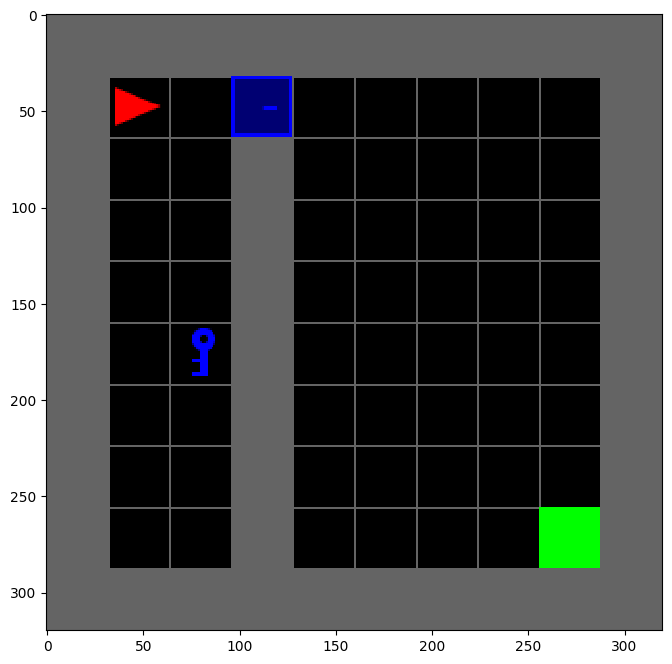

In [ ]:
env = KEYRGBImgObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
obs = env.reset()[0]
print(obs.shape)
screen = env.render()
plt.imshow(screen)

In [ ]:
state_size = obs.shape  # Replace with your actual state size
action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}")
print(f"State size is: {state_size}")

Number of actions: 5
State size is: (320, 320, 3)


## Random action

In [ ]:
env = KEYRGBImgObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
obs = env.reset()
video_filename = '/content/vid.mp4'
max_steps = 100
# Evaluation
with imageio.get_writer(video_filename, fps=10) as video:
  obs = env.reset()
  done = False
  total_reward = 0
  for step in range(max_steps):
      action = env.action_space.sample()
      obs, reward, done, _, _ = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      video.append_data(env.render())
      if done:
        print("done","reward=", total_reward,"num_of_steps=",step)
        break
embed_mp4(video_filename)